# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to reddit.

In [1]:
## IMPORT FEST
import requests
import json
from bs4 import BeautifulSoup
import time
import praw
from requests import Session
import datetime
import pandas as pd
import numpy as np
import re

In [17]:
## instantiating connection to reddit using PRAW
## (Python Reddit API Wrapper)

reddit = praw.Reddit(client_id='I2zMPCz0mPKWTw',
                     client_secret='cRezqYRNxfgWEbx8rlKhKTvxdwQ',
                     password='mydevPw0rd',
                     user_agent='DSI project by Qbot',
                     username='jqdevaccount')

In [19]:
print(reddit.user.me())

jqdevaccount


In [18]:
def age_of_post(submission):
    now = time.mktime(datetime.datetime.now().timetuple())
    return now - submission.created_utc

#### Trying this again. Doing r/nba only.
- Pulling top 1K posts.
- Pulling post ID to link to comments DataFrame, which will be a separate pull (since there are SO .. MANY .. COMMENTS)

In [124]:
titles = []
num_comments = []
post_age = []
subreddit = []
author = []
is_self = []
score = []
stickied = []
link_domain = []
post_id = []

num_posts = 1000

sub = reddit.subreddit('nba')    

for submission in sub.hot(limit=num_posts):
    titles.append(submission.title)
    num_comments.append(submission.num_comments)
    post_age.append(age_of_post(submission))
    author.append(submission.author)
    is_self.append(int(submission.is_self))
    score.append(submission.score)
    stickied.append(int(submission.stickied))
    link_domain.append(submission.domain)
    post_id.append(submission.id)
    time.sleep(1)
    

    

In [2]:
rnba = pd.DataFrame(list(zip(titles, num_comments, post_age, author, 
                     is_self, score, stickied, link_domain, post_id)), 
             columns=['title', 'num_comments', 'post_age', 'author', 
                     'self_post', 'score', 'stickied', 'link_domain', 'post_id'])


rnba.to_csv('./rnba_top1000.csv', index=False)

NameError: name 'titles' is not defined

In [4]:
rnba = pd.read_csv('./rnba_top1000.csv')
rnba.head()

,title,num_comments,post_age,author,self_post,score,stickied,link_domain,post_id
0,/r/NBA Index + Daily Discussion (05.29.2018),275,48579.0,brexbre,1,44,1,self.nba,8mzbgk
1,[Serious Next Day Thread] The Golden State War...,1012,40638.0,DoesNotChodeWell,1,1273,1,self.nba,8n0c3n
2,The Curious Case of Bryan Colangelo and the Se...,895,8479.0,AdonalFoyle,0,3297,0,theringer.com,8n4gs5
3,The last two Sonics players in the NBA (KD and...,459,25326.0,okiedawg,0,6048,0,seattletimes.com,8n2evg
4,In an interview about whether players value wi...,225,17105.0,noahnierenberg,1,1693,0,self.nba,8n3h4u


In [2]:
from nltk.corpus import stopwords

def comments_clean(comment):
    ##credit to Lesson 5.05_nlp_ii
    
    # Remove line breaks and punctuation
    letters_only = re.sub("(^[\r\n]*|[\r\n]+)[\s\t]*[\r\n]+|[!$()=_+|;:\",.<>?]"," ", comment)
    
    # convert to lower, split into individual words
    words = letters_only.lower().split()
    
    # removing stop words
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # putting them back together
    return(" ".join(meaningful_words))

In [131]:
len(post_id) / 4

168.5

In [6]:
post_id = rnba['post_id']

#### Chunk #1: posts 1/4

In [328]:
rnba.head()

,title,num_comments,post_age,author,self_post,score,stickied,link_domain,post_id
0,/r/NBA Index + Daily Discussion (05.29.2018),275,48579.0,brexbre,1,44,1,self.nba,8mzbgk
1,[Serious Next Day Thread] The Golden State War...,1012,40638.0,DoesNotChodeWell,1,1273,1,self.nba,8n0c3n
2,The Curious Case of Bryan Colangelo and the Se...,895,8479.0,AdonalFoyle,0,3297,0,theringer.com,8n4gs5
3,The last two Sonics players in the NBA (KD and...,459,25326.0,okiedawg,0,6048,0,seattletimes.com,8n2evg
4,In an interview about whether players value wi...,225,17105.0,noahnierenberg,1,1693,0,self.nba,8n3h4u


In [48]:
comment_text = []
comment_id = []
comment_score = []
author_flair = []
gilded = []
top_comment = []

In [157]:
id_list = post_id[:168]

for ids in id_list:
    submission = reddit.submission(id=ids)
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(ids)
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        

In [158]:
print(len(comment_text))
print(len(author_flair))

102968
102968


In [159]:
# dfcom1_4 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
#                        columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

# dfcom1_4.to_csv('./dfcom1_4.csv', index=False)

In [90]:
dfcom1_4 = pd.read_csv('./dfcom1_4.csv')

In [110]:
dfcom1_4[~dfcom1_4['post_id'].str.contains('8')]

,post_id,comment_text,comment_score,flair_text,gilded,top_comment
5199,Harden selling an offensive foul and bell taki...,NaN,NaN,NaN,NaN,NaN
5200,That's what's embarrassing.,-17,NBA,0,False,NaN


In [65]:
# min_id = 7
# max_id = 15
# for i in range(len(id_list)):
#     print(id_list[i+min_id])

In [64]:
## testing
min_id = 7
max_id = 15

id_list = post_id[min_id:max_id]

now = time.mktime(datetime.datetime.now().timetuple())

for i in range(len(id_list)):
    ids = i+min_id
    submission = reddit.submission(id=id_list[ids])
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(id_list[ids])
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        
    if i % 3 == 0:
        print('You\'ve pulled comments from',i+1,'thread(s) and it\'s been',(time.mktime(datetime.datetime.now().timetuple()) - now),'seconds')

You've pulled comments from 1 thread(s) and it's been 6.0 seconds
You've pulled comments from 4 thread(s) and it's been 85.0 seconds
You've pulled comments from 7 thread(s) and it's been 138.0 seconds


In [143]:
sum(top_comment) / len(top_comment)

0.15565031982942432

In [146]:
len(post_id) / 4

168.5

In [149]:
169+168+168

505

#### Chunk #2: posts 2/4

In [154]:
print(len(post_id[:168]))
print(len(post_id[168:337]))
print(len(post_id[337:505]))
print(len(post_id[505:]))

168
169
168
169


In [162]:
id_list = post_id[168:337]
print(post_id[168])
print(id_list[0])

8mxjre
8mxjre


In [66]:
comment_text = []
comment_id = []
comment_score = []
author_flair = []
gilded = []
top_comment = []

In [67]:
## chunk2
min_id = 168
max_id = 337

id_list = post_id[min_id:max_id]

now = time.mktime(datetime.datetime.now().timetuple())

for i in range(len(id_list)):
    ids = i+min_id
    submission = reddit.submission(id=id_list[ids])
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(id_list[ids])
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        
    if i % 10 == 0:
        print('You\'ve pulled comments from',i+1,'thread(s) and it\'s been',(time.mktime(datetime.datetime.now().timetuple()) - now),'seconds')

You've pulled comments from 1 thread(s) and it's been 1.0 seconds
You've pulled comments from 11 thread(s) and it's been 17.0 seconds
You've pulled comments from 21 thread(s) and it's been 34.0 seconds
You've pulled comments from 31 thread(s) and it's been 47.0 seconds
You've pulled comments from 41 thread(s) and it's been 57.0 seconds
You've pulled comments from 51 thread(s) and it's been 66.0 seconds
You've pulled comments from 61 thread(s) and it's been 77.0 seconds
You've pulled comments from 71 thread(s) and it's been 87.0 seconds
You've pulled comments from 81 thread(s) and it's been 100.0 seconds
You've pulled comments from 91 thread(s) and it's been 110.0 seconds
You've pulled comments from 101 thread(s) and it's been 120.0 seconds
You've pulled comments from 111 thread(s) and it's been 132.0 seconds
You've pulled comments from 121 thread(s) and it's been 142.0 seconds
You've pulled comments from 131 thread(s) and it's been 150.0 seconds
You've pulled comments from 141 thread(s

In [69]:
dfcom2_4 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
                       columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

dfcom2_4.to_csv('./dfcom2_4.csv', index=False)

In [111]:
dfcom2_4[~dfcom2_4['post_id'].str.contains('8')]

,post_id,comment_text,comment_score,flair_text,gilded,top_comment


In [112]:
dfcom2_4.post_id.nunique()

168

#### Chunk #3: posts 3/4

In [71]:
## chunk3
comment_text = []
comment_id = []
comment_score = []
author_flair = []
gilded = []
top_comment = []

min_id = 337
max_id = 505

id_list = post_id[min_id:max_id]

now = time.mktime(datetime.datetime.now().timetuple())

for i in range(len(id_list)):
    ids = i+min_id
    submission = reddit.submission(id=id_list[ids])
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(id_list[ids])
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        
    if i % 10 == 0:
        print('You\'ve pulled comments from',i+1,'out of',(max_id-min_id),'thread(s) and it\'s taken',(time.mktime(datetime.datetime.now().timetuple()) - now),'seconds')

You've pulled comments from 1 out of 168 thread(s) and it's taken 0.0 seconds
You've pulled comments from 11 out of 168 thread(s) and it's taken 16.0 seconds
You've pulled comments from 21 out of 168 thread(s) and it's taken 23.0 seconds
You've pulled comments from 31 out of 168 thread(s) and it's taken 71.0 seconds
You've pulled comments from 41 out of 168 thread(s) and it's taken 198.0 seconds
You've pulled comments from 51 out of 168 thread(s) and it's taken 313.0 seconds
You've pulled comments from 61 out of 168 thread(s) and it's taken 327.0 seconds
You've pulled comments from 71 out of 168 thread(s) and it's taken 353.0 seconds
You've pulled comments from 81 out of 168 thread(s) and it's taken 394.0 seconds
You've pulled comments from 91 out of 168 thread(s) and it's taken 410.0 seconds
You've pulled comments from 101 out of 168 thread(s) and it's taken 425.0 seconds
You've pulled comments from 111 out of 168 thread(s) and it's taken 536.0 seconds
You've pulled comments from 121 

In [142]:
# dfcom3_4 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
#                        columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

# dfcom3_4.to_csv('./dfcom3_4.csv', index=False)

In [133]:
id_list = post_id[168:337]

for ids in id_list:
    submission = reddit.submission(id=ids)
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(ids)
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
    
    if ids%10:
        print('You\'ve pulled through id#',ids)

In [113]:
dfcom4_1[~dfcom3_4['post_id'].str.contains('8')]

,post_id,comment_text,comment_score,flair_text,gilded,top_comment


#### Chunk #4: posts 4/4

In [163]:
## chunk4.1

comment_text = []
comment_id = []
comment_score = []
author_flair = []
gilded = []
top_comment = []


min_id = 505
max_id = 562

id_list = post_id[min_id:max_id]

now = time.mktime(datetime.datetime.now().timetuple())

for i in range(len(id_list)):
    ids = i+min_id
    submission = reddit.submission(id=id_list[ids])
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(id_list[ids])
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        
    if i % 10 == 0:
        print('You\'ve pulled comments from',i+1,'out of',(max_id-min_id),'thread(s) and it\'s been',(time.mktime(datetime.datetime.now().timetuple()) - now),'seconds')

You've pulled comments from 1 out of 57 thread(s) and it's been 1.0 seconds
You've pulled comments from 11 out of 57 thread(s) and it's been 27.0 seconds
You've pulled comments from 21 out of 57 thread(s) and it's been 36.0 seconds
You've pulled comments from 31 out of 57 thread(s) and it's been 46.0 seconds
You've pulled comments from 41 out of 57 thread(s) and it's been 63.0 seconds
You've pulled comments from 51 out of 57 thread(s) and it's been 73.0 seconds


In [164]:
dfcom4_1 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
                       columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

dfcom4_1.to_csv('./dfcom4_1.csv', index=False)

In [151]:
post_id[560:570]

560    8mmx5h
561    8mwv17
562    8n3c83
563    8mlo7f
564    8mqq1z
565    8mu55c
566    8mq4iy
567    8mtrzc
568    8mzlbo
569    8mlwk6
Name: post_id, dtype: object

In [156]:
url = 'https://www.reddit.com/8n3c83/.json'
res = requests.get(url)

# soup = BeautifulSoup(res.content, 'lxml')
res.status_code

429

In [161]:
505 + len(set(comment_id))

563

In [173]:
post_id[563]

'8mlo7f'

In [171]:
## chunk4.2
min_id = 564
max_id = len(post_id)-1

id_list = post_id[min_id:max_id]

now = time.mktime(datetime.datetime.now().timetuple())

for i in range(len(id_list)):
    ids = i+min_id
    submission = reddit.submission(id=id_list[ids])
    submission.comments.replace_more(limit=None)
    
    for comment in submission.comments.list():
        comment_text.append(comment.body)
        comment_id.append(id_list[ids])
        comment_score.append(comment.score)
        author_flair.append(comment.author_flair_text)
        gilded.append(comment.gilded)
        top_comment.append(comment.is_root)
        
    if i % 10 == 0:
        print('You\'ve pulled comments from',i+1,'out of',(max_id-min_id),'thread(s) and it\'s been',(time.mktime(datetime.datetime.now().timetuple()) - now),'seconds')

You've pulled comments from 1 out of 109 thread(s) and it's been 1.0 seconds
You've pulled comments from 11 out of 109 thread(s) and it's been 17.0 seconds
You've pulled comments from 21 out of 109 thread(s) and it's been 29.0 seconds
You've pulled comments from 31 out of 109 thread(s) and it's been 43.0 seconds
You've pulled comments from 41 out of 109 thread(s) and it's been 58.0 seconds
You've pulled comments from 51 out of 109 thread(s) and it's been 71.0 seconds
You've pulled comments from 61 out of 109 thread(s) and it's been 84.0 seconds
You've pulled comments from 71 out of 109 thread(s) and it's been 96.0 seconds
You've pulled comments from 81 out of 109 thread(s) and it's been 108.0 seconds
You've pulled comments from 91 out of 109 thread(s) and it's been 122.0 seconds
You've pulled comments from 101 out of 109 thread(s) and it's been 131.0 seconds


In [174]:
dfcom4_2 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
                       columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

dfcom4_2.to_csv('./dfcom4_2.csv', index=False)

In [179]:
len(post_id) - dfcom4_2.post_id.nunique()

508

In [180]:
comment_text = []
comment_id = []
comment_score = []
author_flair = []
gilded = []
top_comment = []

submission = reddit.submission(id=post_id[563])
submission.comments.replace_more(limit=None)
    
for comment in submission.comments.list():
    comment_text.append(comment.body)
    comment_id.append(id_list[ids])
    comment_score.append(comment.score)
    author_flair.append(comment.author_flair_text)
    gilded.append(comment.gilded)
    top_comment.append(comment.is_root)

In [183]:
dfcom4_3 = pd.DataFrame(list(zip(comment_id, comment_text, comment_score, author_flair, gilded, top_comment)),
                       columns= ['post_id', 'comment_text', 'comment_score', 'flair_text', 'gilded', 'top_comment'])

dfcom4_3.to_csv('./dfcom4_3.csv', index=False)

** MEGA-CONCATENATE INTO ONE DF, DROP DUPLICATE ROWS FROM CHUNK 3 ERROR**

dfcom_14 + dfcom_24 + FIX dfcom_34 + dfcom_4_2+dfcom_4_3

In [219]:
dfcom3_4_fixed = dfcom3_4.loc[max(dfcom2_4.index)+1:]

In [ ]:
## drop screwed up rows from chunk 1

In [222]:
dfcom4_2.post_id.nunique()+dfcom4_3.post_id.nunique()

167

In [228]:
comments_full = pd.concat([dfcom1_4, dfcom2_4, dfcom3_4_fixed, dfcom4_2])

In [229]:
comments_full.to_csv('./comments_full.csv', index=False)

In [370]:
comms_clean = comms_clean.reset_index(drop=True)

#### Saving to csv

In [127]:
# len(id)

Series([], Name: post_id, dtype: object)

In [365]:
# all_comments = pd.DataFrame(list(zip(comment_id, comment_text, score, author_flair, gilded, top_comment)), 
#                             columns=['comment_id', 'comment_text', 'score', 'author_flair', 'gilded', 'top_comment'])

# all_comments.to_csv('./rnba_comments_top1000.csv', index=False)

In [366]:
# all_comments.head()

In [367]:
# all_comments['clean_comment'] = all_comments['comment_text'].map(comments_clean)

In [368]:
# len(comments)

In [369]:
# comments_full.head()

** Next steps**

- general cleaning
- clean flair
- cast `top_comment` as int
- clean out deleted comments
- then ... MODELING!

In [3]:
comments_full = pd.read_csv('./comments_full.csv')
comments_full.head()

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,post_id,comment_text,comment_score,flair_text,gilded,top_comment
0,8mzbgk,Serena Williams did voice work in avatar the l...,31,[GSW] Kevin Durant,0,True
1,8mzbgk,r/nba on suicide watch,33,Spurs,0,True
2,8mzbgk,Told my wife this and might as well tell r/nba...,18,Cavaliers,0,True
3,8mzbgk,is everyone okay? everyone get some good sleep...,32,Mavericks,0,True
4,8mzbgk,banh mi is the shit,14,[MIL] Sterling Brown,0,True


In [4]:
comms_clean = comments_full.drop(comments_full[~comments_full.post_id.str.contains('8')].index)

In [8]:
# comms_clean = comms_clean.reset_index(drop=True)

In [5]:
## check for nulls

comms_clean.isnull().sum()

post_id              0
comment_text         0
comment_score        1
flair_text       39337
gilded               1
top_comment          1
dtype: int64

In [6]:
comms_clean = comms_clean.drop(comms_clean[comms_clean.comment_score.isnull()].index)

In [7]:
comms_clean.isnull().sum()

post_id              0
comment_text         0
comment_score        0
flair_text       39336
gilded               0
top_comment          0
dtype: int64

In [8]:
## casting top_comment as int for later model use
comms_clean.top_comment = comms_clean.top_comment.astype(int)

In [15]:
comms_clean.head()

,post_id,comment_text,comment_score,flair_text,gilded,top_comment
0,8mzbgk,Serena Williams did voice work in avatar the l...,31,[GSW] Kevin Durant,0,1
1,8mzbgk,r/nba on suicide watch,33,Spurs,0,1
2,8mzbgk,Told my wife this and might as well tell r/nba...,18,Cavaliers,0,1
3,8mzbgk,is everyone okay? everyone get some good sleep...,32,Mavericks,0,1
4,8mzbgk,banh mi is the shit,14,[MIL] Sterling Brown,0,1


In [9]:
mask = comms_clean[comms_clean['comment_text'] == '[deleted]']

comms_clean = comms_clean.drop(mask.index)

Alright, time to clean some flair!! Let's first fill the nulls with 'no_flair' to categorize, b/c we're gonna make dummies

In [10]:
comms_clean.flair_text = comms_clean.flair_text.fillna('no_flair')

In [11]:
comms_clean.isnull().sum()

post_id          0
comment_text     0
comment_score    0
flair_text       0
gilded           0
top_comment      0
dtype: int64

Great, now we can go to work. We know that there are two types of flairs: 
- ones with player names that start with 3 letter team, e.g. [NYK] Patrick Ewing
- ones that are just team, e.g. Lakers

In [21]:
#type 1
print(comms_clean[comms_clean.flair_text.str.contains('\[')]['flair_text'].unique())
print(comms_clean[comms_clean.flair_text.str.contains('\[')]['flair_text'].nunique())

['[GSW] Kevin Durant' '[MIL] Sterling Brown' '[LAL] Kobe Bryant' ...
 '[DAL] Dan Dickau' '[HOU] Ryan Anderson' '[BKN] Drazen Petrovic']
1014


In [12]:
#type 1
## okay - this seemed to work. let's figure out how to map it with the appropriate index.
short_flair = comms_clean[comms_clean.flair_text.str.contains('\[')]['flair_text'].map(lambda x: x[1:4])
short_flair.head()

0     GSW
4     MIL
13    LAL
15    LAL
16    OKC
Name: flair_text, dtype: object

In [13]:
long_flair = comms_clean[~comms_clean.flair_text.str.contains('\[')]
print(long_flair['flair_text'].unique())
print()
print(long_flair['flair_text'].nunique())

['Spurs' 'Cavaliers' 'Mavericks' 'Pistons' 'Pelicans' 'Celtics' '76ers'
 'Nuggets' 'no_flair' 'Warriors Bandwagon' 'Clippers'
 'Mavericks Tankwagon' 'Cavaliers Bandwagon' 'Wizards' 'Knicks' 'Hornets'
 'Raptors' 'Warriors' 'Knicks Tankwagon' 'Rockets Bandwagon' 'Bulls'
 'Lakers' 'Thunder' 'NBA' 'Suns' 'Bulls Tankwagon' 'Rockets'
 'Trail Blazers' 'Suns Tankwagon' 'Jazz Bandwagon' 'Jazz' 'Timberwolves'
 'West' 'Heat' 'Supersonics' 'Nets Tankwagon' 'Bucks' 'Knicks Tankswagon'
 'Grizzlies' 'Pacers' 'Hawks Tankwagon' 'Celtics Bandwagon'
 '76ers Bandwagon' 'Spurs Bandwagon' 'Nets' 'Hawks' 'San Diego Rockets'
 'Lakers Bandwagon' 'Kings Tankwagon' 'Suns Bandwagon'
 'Mavericks Bandwagon' 'Bullets' 'Magic' 'Canada' 'East'
 'Charlotte Hornets' 'Kings' 'Grizzlies Tankwagon' 'Thunder Bandwagon'
 'Pacers Bandwagon' 'Raptors Bandwagon' 'Bleacher Report'
 'New Jersey Nets' 'Vancouver Grizzlies' 'Trust The Process'
 'Sixers Bandwagon' 'Magic Tankwagon' 'Timberwolves Bandwagon'
 'Kings Bandwagon' 'Genera

In [14]:
word = 'Wolves Bandwagon'
re.match('^\w+', word).group(0).lower()

'wolves'

In [15]:
re.findall('^\w+', word)

['Wolves']

In [16]:
long_flair['flair_text'].map(lambda x: re.findall('^\w+', x)[0].lower()).unique()

array(['spurs', 'cavaliers', 'mavericks', 'pistons', 'pelicans',
       'celtics', '76ers', 'nuggets', 'no_flair', 'warriors', 'clippers',
       'wizards', 'knicks', 'hornets', 'raptors', 'rockets', 'bulls',
       'lakers', 'thunder', 'nba', 'suns', 'trail', 'jazz',
       'timberwolves', 'west', 'heat', 'supersonics', 'nets', 'bucks',
       'grizzlies', 'pacers', 'hawks', 'san', 'kings', 'bullets', 'magic',
       'canada', 'east', 'charlotte', 'bleacher', 'new', 'vancouver',
       'trust', 'sixers', 'generals', 'toaster', '23', 'mavs',
       'knickerbockers', 'minneapolis', 'usa', 'philippines', 'braves',
       'dirk', 'huskies', 'toronto', '24', 'bobcats', 'lithuania',
       'wolves', 'australia', 'okc', 'hakeem', 'finland', '59', 'france',
       'kobe', 'croatia', 'i', 'serbia', 'brooklyn', 'jon', 'jason',
       'allen', 'braxton'], dtype=object)

In [17]:
full_names = ["Celtics",
"Nets",
"Knicks",
"76ers",
"Raptors",
"Bulls",
"Cavaliers",
"Pistons",
"Pacers",
"Bucks",
"Hawks",
"Hornets",
"Heat",
"Magic",
"Wizards",
"Nuggets",
 "Timberwolves",
"Thunder",
"Blazers",
"Jazz",
"Warriors",
"Clippers",
"Lakers",
"Suns",
"Kings",
"Mavericks",
"Rockets",
"Grizzlies",
"Pelicans",
"Spurs"]

In [18]:
full_names = [team.lower() for team in full_names]

In [19]:
short_teams = ["BOS",
"BKN",
"NYK",
"PHI",
"TOR",
"CHI",
"CLE",
"DET",
"IND",
"MIL",
"ATL",
"CHA",
"MIA",
"ORL",
"WAS",
"DEN",
"MIN",
"OKC",
"POR",
"UTA",
"GSW",
"LAC",
"LAL",
"PHO",
"SAC",
"DAL",
"HOU",
"MEM",
"NOP",
"SAS"]

In [20]:
nba_dict = dict(zip(full_names, short_teams))

In [21]:
nba_dict

{'celtics': 'BOS',
 'nets': 'BKN',
 'knicks': 'NYK',
 '76ers': 'PHI',
 'raptors': 'TOR',
 'bulls': 'CHI',
 'cavaliers': 'CLE',
 'pistons': 'DET',
 'pacers': 'IND',
 'bucks': 'MIL',
 'hawks': 'ATL',
 'hornets': 'CHA',
 'heat': 'MIA',
 'magic': 'ORL',
 'wizards': 'WAS',
 'nuggets': 'DEN',
 'timberwolves': 'MIN',
 'thunder': 'OKC',
 'blazers': 'POR',
 'jazz': 'UTA',
 'warriors': 'GSW',
 'clippers': 'LAC',
 'lakers': 'LAL',
 'suns': 'PHO',
 'kings': 'SAC',
 'mavericks': 'DAL',
 'rockets': 'HOU',
 'grizzlies': 'MEM',
 'pelicans': 'NOP',
 'spurs': 'SAS'}

In [22]:
comms_clean.head()

,post_id,comment_text,comment_score,flair_text,gilded,top_comment
0,8mzbgk,Serena Williams did voice work in avatar the l...,31,[GSW] Kevin Durant,0,1
1,8mzbgk,r/nba on suicide watch,33,Spurs,0,1
2,8mzbgk,Told my wife this and might as well tell r/nba...,18,Cavaliers,0,1
3,8mzbgk,is everyone okay? everyone get some good sleep...,32,Mavericks,0,1
4,8mzbgk,banh mi is the shit,14,[MIL] Sterling Brown,0,1


**Next steps**

- create new 'flair_clean1' column
- for loop #1: get short-name out of [brackets], clean and lower other flair type
- create new 'flair_clean2' column
- for loop #2: map with dict

In [23]:
comms_clean['flair_clean1'] = ''

In [24]:
flair_clean1_list = []
for i in comms_clean['flair_text']:
    if i.find(']') > 0:
        flair_clean1_list.append(i[1:4])
    else:
        try:
            flair_clean1_list.append(re.findall('^\w+', i)[0].lower())
        except:
            flair_clean1_list.append('other')

In [25]:
len(flair_clean1_list), len(comms_clean.flair_text)

(145309, 145309)

In [26]:
comms_clean['flair_clean1'] = flair_clean1_list

In [27]:
comms_clean.head()

,post_id,comment_text,comment_score,flair_text,gilded,top_comment,flair_clean1
0,8mzbgk,Serena Williams did voice work in avatar the l...,31,[GSW] Kevin Durant,0,1,GSW
1,8mzbgk,r/nba on suicide watch,33,Spurs,0,1,spurs
2,8mzbgk,Told my wife this and might as well tell r/nba...,18,Cavaliers,0,1,cavaliers
3,8mzbgk,is everyone okay? everyone get some good sleep...,32,Mavericks,0,1,mavericks
4,8mzbgk,banh mi is the shit,14,[MIL] Sterling Brown,0,1,MIL


In [28]:
comms_clean['flair_clean2'] = ''

In [29]:
flair_clean2_list = []
for i in comms_clean['flair_clean1']:
    if nba_dict.get(i) is None:
        if i == 'no_flair':
            flair_clean2_list.append('no_flair')
        else:
            flair_clean2_list.append('other')
    else:
        flair_clean2_list.append(nba_dict.get(i))

In [30]:
comms_clean['flair_clean2'] = flair_clean2_list

In [31]:
comms_clean.flair_clean2.unique()

array(['other', 'SAS', 'CLE', 'DAL', 'DET', 'NOP', 'BOS', 'PHI', 'DEN',
       'no_flair', 'GSW', 'LAC', 'WAS', 'NYK', 'CHA', 'TOR', 'HOU', 'CHI',
       'LAL', 'OKC', 'PHO', 'UTA', 'MIN', 'MIA', 'BKN', 'MIL', 'MEM',
       'IND', 'ATL', 'SAC', 'ORL'], dtype=object)

In [32]:
from plotter import *
import plotter

In [33]:
comms_clean.dtypes

post_id          object
comment_text     object
comment_score    object
flair_text       object
gilded           object
top_comment       int32
flair_clean1     object
flair_clean2     object
dtype: object

In [34]:
comms_clean['comment_score'] = comms_clean['comment_score'].astype(int)
comms_clean['gilded'] = comms_clean['gilded'].astype(int)

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


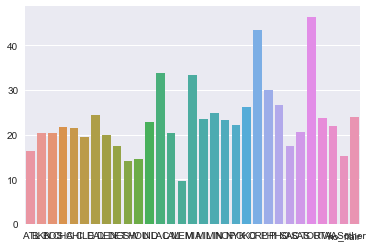

In [35]:
plot_groupby(comms_clean, 'comment_score', 'flair_clean2')

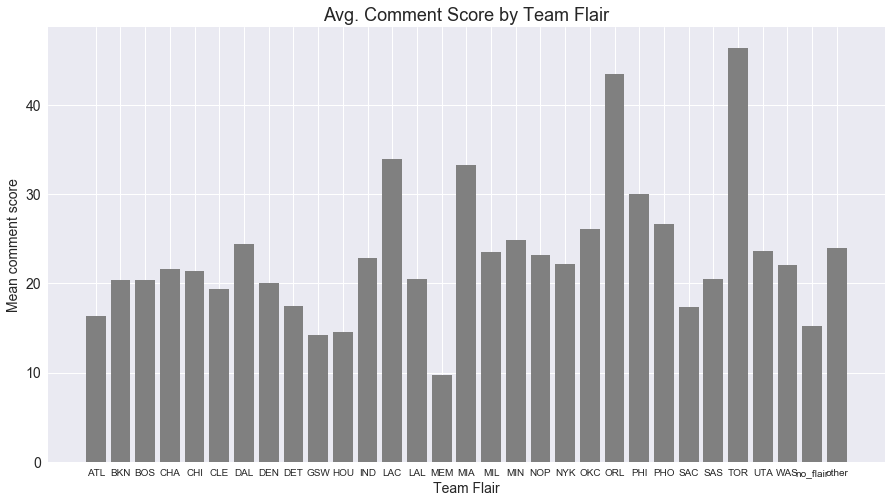

In [36]:
fig = plt.figure(figsize = (15, 8))


test = np.ndarray.tolist(comms_clean['flair_clean2'].unique())
    
for i in test:
    try:
        if math.isnan(float(i)):
            test.remove(i)
    except:
        pass

plt.bar(x=sorted(test), height=[i for i in comms_clean.groupby('flair_clean2')['comment_score'].agg('mean')], color='gray');

plt.yticks(fontsize=14);
plt.xlabel('Team Flair', fontsize=14);
plt.ylabel('Mean comment score', fontsize=14);
plt.title('Avg. Comment Score by Team Flair', fontsize=18);

In [37]:
game_threads = ['8mvx3q', '8mukqm', '8mmx15', '8mlo7f']

comms_clean['game_thread'] = comms_clean['post_id'].map(lambda x: 1 if x in game_threads else 0)

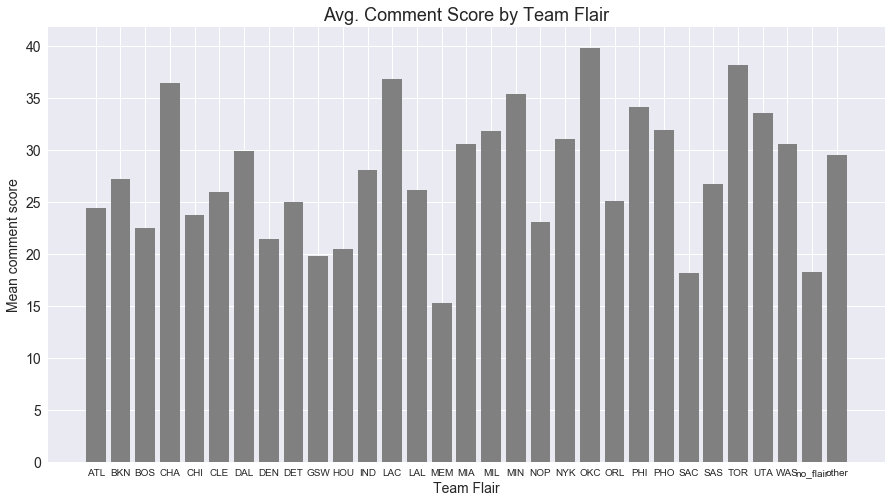

In [38]:
no_gt = comms_clean[comms_clean['game_thread']==0]

fig = plt.figure(figsize = (15, 8))


test = np.ndarray.tolist(no_gt['flair_clean2'].unique())
    
for i in test:
    try:
        if math.isnan(float(i)):
            test.remove(i)
    except:
        pass

plt.bar(x=sorted(test), height=[i for i in no_gt.groupby('flair_clean2')['comment_score'].agg('mean')], color='gray');

plt.yticks(fontsize=14);
plt.xlabel('Team Flair', fontsize=14);
plt.ylabel('Mean comment score', fontsize=14);
plt.title('Avg. Comment Score by Team Flair', fontsize=18);

In [127]:
# rnbafull = pd.read_csv('./rnba_top1000.csv')

In [445]:
# rnba.to_csv('./rnba_top10_initial.csv', index=False)
# all_comments.to_csv('./rnba_comments_top10.csv', index=False)

**BORDER**
___________________________
**BORDER**

### Now, we're going to start some modeling.

**Next Steps**

1. dummy features off of flair
2. CVEC or TF-IDF on comment_text corpus
3. Put into logreg for both importance AND direction of coefs
4. Decision tree just returns importance of coefs
5. Zip back up into list with feature names

**1: Dummy features from flair**

In [39]:
model_df = comms_clean.drop(['flair_text', 'flair_clean1'], axis=1)
model_df.rename({'flair_clean2':'flair'}, axis=1, inplace=True)
model_df.head()

,post_id,comment_text,comment_score,gilded,top_comment,flair,game_thread
0,8mzbgk,Serena Williams did voice work in avatar the l...,31,0,1,other,0
1,8mzbgk,r/nba on suicide watch,33,0,1,SAS,0
2,8mzbgk,Told my wife this and might as well tell r/nba...,18,0,1,CLE,0
3,8mzbgk,is everyone okay? everyone get some good sleep...,32,0,1,DAL,0
4,8mzbgk,banh mi is the shit,14,0,1,other,0


In [121]:
model_df.groupby('flair')['comment_score'].agg('mean').sort_values(ascending=False)

flair
TOR         46.435309
ORL         43.510386
LAC         33.897759
MIA         33.268179
PHI         30.072191
PHO         26.629020
OKC         26.082474
MIN         24.812749
DAL         24.409738
other       24.017261
UTA         23.642341
MIL         23.564959
NOP         23.197617
IND         22.858763
NYK         22.226960
WAS         22.030848
CHA         21.630975
CHI         21.398124
SAS         20.487381
LAL         20.464866
BOS         20.396935
BKN         20.328849
DEN         20.011136
CLE         19.360089
DET         17.435233
SAC         17.335159
ATL         16.397810
no_flair    15.204274
HOU         14.541991
GSW         14.167179
MEM          9.684438
Name: comment_score, dtype: float64

In [119]:
## save this for later: 
# corpus = model_df['comment_text']

In [40]:
dummy_df = model_df[['gilded', 'top_comment', 'game_thread', 'flair']]

In [41]:
dummy_df = pd.get_dummies(dummy_df, columns=['flair'])

In [42]:
dummy_df.head(3)

,gilded,top_comment,game_thread,flair_ATL,flair_BKN,flair_BOS,flair_CHA,flair_CHI,flair_CLE,flair_DAL,...,flair_ORL,flair_PHI,flair_PHO,flair_SAC,flair_SAS,flair_TOR,flair_UTA,flair_WAS,flair_no_flair,flair_other
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


**2. CVEC the comment text!**

In [43]:
## separating out into game thread and non-game thread posts
ready_df = pd.concat([model_df[['comment_text', 'comment_score']], dummy_df], axis=1)

In [44]:
ready_df['gilded'] = ready_df['gilded'].map(lambda x: 1 if x>=1 else 0)

In [45]:
ready_nogt = ready_df[ready_df['game_thread']==0]
ready_gt = ready_df[ready_df['game_thread']==1]

In [46]:
gt_med = ready_gt['comment_score'].median()
ngt_med = ready_nogt['comment_score'].median()

ready_gt['target'] = ready_gt['comment_score'].map(lambda x: 1 if x>= gt_med else 0)
ready_nogt['target'] = ready_nogt['comment_score'].map(lambda x: 1 if x>= ngt_med else 0)

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
print(ready_gt['target'].value_counts())
print()
print(ready_nogt['target'].value_counts())

1    55924
0     5804
Name: target, dtype: int64

1    50458
0    33123
Name: target, dtype: int64


In [2]:
ready_gt.to_csv('./ready_gt.csv')
ready_nogt.to_csv('./ready_nogt.csv')

NameError: name 'ready_gt' is not defined

** read in `ready_gt` and `ready_nogt` csv's here if re-starting **

In [2]:
ready_gt = pd.read_csv('./ready_gt.csv', index_col=0)
ready_nogt = pd.read_csv('./ready_nogt.csv', index_col=0)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
ready_nogt.head(3)

,comment_text,comment_score,gilded,top_comment,game_thread,flair_ATL,flair_BKN,flair_BOS,flair_CHA,flair_CHI,...,flair_PHI,flair_PHO,flair_SAC,flair_SAS,flair_TOR,flair_UTA,flair_WAS,flair_no_flair,flair_other,target
0,Serena Williams did voice work in avatar the l...,31,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,r/nba on suicide watch,33,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,Told my wife this and might as well tell r/nba...,18,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
ready_gt.head(3)

,comment_text,comment_score,gilded,top_comment,game_thread,flair_ATL,flair_BKN,flair_BOS,flair_CHA,flair_CHI,...,flair_PHI,flair_PHO,flair_SAC,flair_SAS,flair_TOR,flair_UTA,flair_WAS,flair_no_flair,flair_other,target
15689,If Trevor Ariza and Terry Rozier were the shoo...,8567,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
15690,LeBron should just rent a place in the Bay Area.,5776,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
15691,crazy how similar these last two games 7s were...,3466,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [51]:
masky = ['flair_'+i for i in short_teams]
# masky.append('comment_score')
masky.remove('flair_POR')

In [52]:
masky[0][-3:]

'BOS'

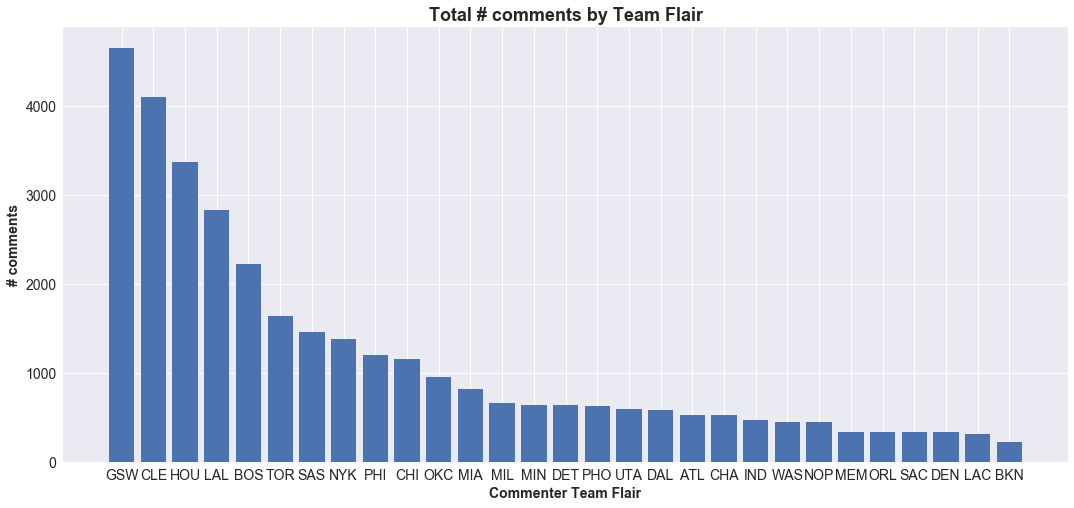

In [53]:
fig = plt.figure(figsize = (18, 8))

thingy = ready_gt[masky].sum()

plt.title('Total # comments by Team Flair', fontsize=18, weight='bold');

plt.bar([i[-3:] for i in thingy.sort_values(ascending=False).index], thingy.sort_values(ascending=False));
plt.tick_params(labelsize=14);
plt.ylabel('# comments', fontsize=14, weight='bold');
plt.xlabel('Commenter Team Flair', fontsize=14, weight='bold');

**2. Let's TTS, then CVEC. **

Will do process on Not Game Threads first, then repeat with Game Threads.

In [4]:
from scipy.signal import resample

In [5]:
## Taking random sample of half of the train data, since the last 3 attempts with the full set triggered memory errors :(
np.random.seed(22)
Xn = ready_nogt.drop(['target', 'comment_score', 'gilded'], axis=1)
Xn = Xn.loc[np.random.choice(Xn.index, size=int(np.round(Xn.shape[0]*.5)), replace=False)]
yn = ready_nogt.loc[Xn.index, 'target']

In [7]:
Xn.shape, yn.shape

((41790, 34), (41790,))

In [6]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, random_state=22)

In [54]:
# ## creating X and y sets. Dropping comment_score and gilded since they are probably 
# ## too collinear to high/low comment score

# Xn = ready_nogt.drop(['target', 'comment_score', 'gilded'], axis=1)
# yn = ready_nogt['target']
# Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, random_state=22)

** Let's setup a pipeline to make the CVEC transformation easier **

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

#### Make your own class/function that:
1. takes in df
2. splits out comment_text column
3. CVEC (fit) transforms it (??)
4. re-concates to orig dummies
5. returns df you can put in pipeline?

In [8]:
# def cvec_readier(df, text_col):
#     '''Takes DataFrame w/ dummies and text column label as args.
#     Separates two
#     '''
#     df1 = df.drop(text_col, axis=1)
#     df2 = df[[text_col]]
    
#     corpus = df2[text_col]
    
#     new_corp = cvec.transform(corpus)
    
#     return pd.concat([pd.DataFrame(new_corp.todense(), columns=cvec.get_feature_names()), df1], axis=1)

In [9]:
cvec = CountVectorizer(stop_words='english')
new_tr = cvec.fit_transform(Xn_train['comment_text'])
new_te = cvec.transform(Xn_test['comment_text'])

Xn_train = Xn_train.drop('comment_text', axis=1)
Xn_test = Xn_test.drop('comment_text', axis=1)

In [10]:
# Xn_train.sum().sort_values(ascending=False)

In [11]:
# text_df = pd.DataFrame(new_tr.todense(), columns=cvec.get_feature_names())

In [12]:
# text_df.shape

In [13]:
# text_df.sum().sort_values(ascending=False).head(50)

In [14]:
Xn_train_cvec = pd.concat([Xn_train, pd.DataFrame(new_tr.todense(), columns=cvec.get_feature_names(), index=Xn_train.index)], axis=1)

In [15]:
Xn_train_cvec.shape

(31342, 21207)

In [16]:
Xn_test_cvec = pd.concat([Xn_test, pd.DataFrame(new_te.todense(), columns=cvec.get_feature_names(), index=Xn_test.index.values)], axis=1)

In [17]:
Xn_test_cvec.shape

(10448, 21207)

In [16]:
# Xn_train_cvec.to_csv('./Xn_train_cvec_comms.csv')
# Xn_test_cvec.to_csv('./Xn_test_cvec_comms.csv')

In [ ]:
### Xn_train_cvec.isnull().sum().sum()

In [37]:
Xn_train_cvec.head()

,top_comment,game_thread,flair_ATL,flair_BKN,flair_BOS,flair_CHA,flair_CHI,flair_CLE,flair_DAL,flair_DEN,...,zygote,zynw6,zyt4hhp,zyyygoat,ée,éwee,ಠ_ಠ,彡ﾉ,詹姆斯牛逼,ﾌﾌ
96378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137906,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
logpipe_ng = Pipeline([
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression())
])

In [18]:
# logpipe_ng.fit(Xn_train_cvec, yn_train)

# logpipe_ng.score(Xn_test_cvec, yn_test)

In [492]:
# param_grid = {
#     'cvec__max_features': [300000, None],
#     'logreg__penalty': ['l2', 'l1']
# }

# param_grid = {}

# gs_ng = GridSearchCV(logpipe_ng, param_grid, n_jobs=2, verbose=1)
# gs_ng.fit(Xn_train, yn_train)

In [19]:
rf = RandomForestClassifier(n_jobs=-1, verbose=1)
rf.fit(Xn_train_cvec, yn_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   14.6s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [20]:
rf.score(Xn_test_cvec, yn_test)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished


0.5461332312404288

In [21]:
from sklearn.model_selection import cross_val_score

In [31]:
print(cross_val_score(rf, Xn_test_cvec, yn_test))
print(cross_val_score(rf, Xn_test_cvec, yn_test).mean())

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[0.54550675 0.53718059 0.54623779]


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


0.5480480421053349


In [23]:
coef_df = pd.DataFrame(data=list(rf.feature_importances_), columns=['feature_weight'], index=list(Xn_train_cvec.columns)).sort_values(by='feature_weight', ascending=False).head(10)

In [24]:
coef_df

,feature_weight
top_comment,0.009293
flair_no_flair,0.005241
flair_other,0.004538
like,0.003874
game,0.003872
just,0.003569
lebron,0.003489
team,0.003056
flair_GSW,0.003041
lol,0.003040


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

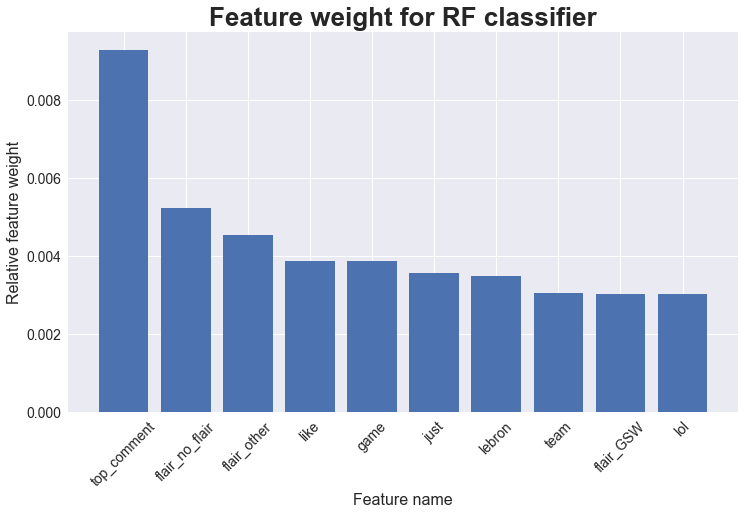

In [32]:
fig = plt.figure(figsize=(12,7));

plt.bar(x=coef_df.index, height=coef_df['feature_weight']);
plt.tick_params(labelsize=14);
plt.xticks(rotation=45);
plt.title('Feature weight for RF classifier', fontsize=26, weight='bold');
plt.ylabel('Relative feature weight', fontsize=16);
plt.xlabel('Feature name', fontsize=16);

In [35]:
from sklearn import metrics
threshold = np.arange(0, 1.01, .01)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


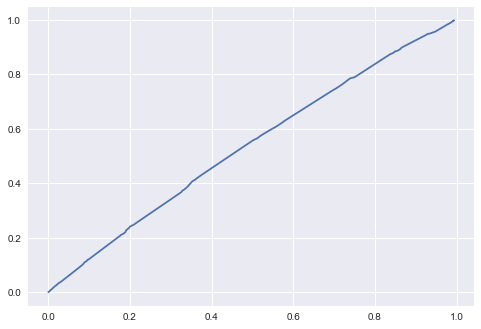

In [37]:
scores_rc = []
scores_sp = []
yprob = rf.predict_proba(Xn_test_cvec)[:,1]


for i in threshold:
    probas = (yprob > i).astype(int)
    rc = metrics.recall_score(yn_test, probas)
    
    tn, fp, fn, tp = metrics.confusion_matrix(yn_test, probas).ravel()
    sp = tn / (tn+fp)
    
    scores_rc.append(rc)
    scores_sp.append(sp)


plt.plot([1-i for i in scores_sp], scores_rc);

## Executive Summary

- **The Problem:** Can we predict whether an r/nba comment will get a high score, based on the text and its commenter’s team fandom?
- **The Data:** ~700 r/nba posts, >180K comments, pulled via Reddit API
- **The Process:** Cleaned, engineered and modeled 41K comments to try and predict high/low comment scores based on team flair and comment text


- **Key Findings:**
    - Stake your claim: Original top comments scored better than replies to other comments
    - Show yourself (except sometimes): Comment score depends on having team flair, but some teams are not well-liked
- **Next Steps:**
    - More computational power needed for additional model exploration, model tuning, feature engineering and analysis
